# Import

## Modules

In [425]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Data

In [510]:
raw_cases_data = pd.read_csv('https://data.nsw.gov.au/data/dataset/97ea2424-abaf-4f3e-a9f2-b5c883f42b6a/resource/2776dbb8-f807-4fb2-b1ed-184a6fc2c8aa/download/confirmed_cases_table4_location_likely_source.csv')
raw_tests_data = pd.read_csv("https://data.nsw.gov.au/data/dataset/5424aa3b-550d-4637-ae50-7f458ce327f4/resource/227f6b65-025c-482c-9f22-a25cf1b8594f/download/covid-19-tests-by-date-and-location-and-result.csv")



# Preprocessing

In [511]:
raw_cases_data["notification_date"] = pd.to_datetime(raw_cases_data["notification_date"])
raw_tests_data["test_date"] = pd.to_datetime(raw_tests_data["test_date"])

# Audit

In [512]:
raw_cases_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8342 entries, 0 to 8341
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   notification_date           8342 non-null   datetime64[ns]
 1   postcode                    7534 non-null   object        
 2   likely_source_of_infection  8342 non-null   object        
 3   lhd_2010_code               7523 non-null   object        
 4   lhd_2010_name               7523 non-null   object        
 5   lga_code19                  7523 non-null   float64       
 6   lga_name19                  7523 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 456.3+ KB


# Subset

In [513]:
cases_df = raw_cases_data.query("notification_date >= '2021-06-01' & likely_source_of_infection != 'Overseas'")

# Cases Analysis

In [514]:
cases_agg = cases_df.groupby("notification_date").count().iloc[:, 0].to_frame(name="Count")
cases_agg.reset_index(inplace=True)
cases_agg.sort_values(by="notification_date", inplace=True, ascending=True)
cases_agg["Pct Change"] = cases_agg["Count"].pct_change()
cases_agg["Cumsum"] = cases_agg["Count"].cumsum()
cases_agg["Daily Difference"] = cases_agg["Count"].diff()
cases_agg["Growth Factor"] = cases_agg["Daily Difference"] / cases_agg["Daily Difference"].shift(1)
cases_agg["Weekly Rolling Average"] = cases_agg["Count"].rolling(window=7).mean()

In [515]:
idx = cases_agg['Cumsum'].sub(100).abs().idxmin()
cases_agg["Epidemiological Days"]  = (cases_agg["notification_date"] - cases_agg.loc[idx, "notification_date"]) / np.timedelta64(1, 'D')

In [516]:
cases_agg

,notification_date,Count,Pct Change,Cumsum,Daily Difference,Growth Factor,Weekly Rolling Average,Epidemiological Days
0,2021-06-16,3,NaN,3,NaN,NaN,NaN,-9.0
1,2021-06-17,1,-0.666667,4,-2.0,NaN,NaN,-8.0
2,2021-06-18,2,1.000000,6,1.0,-0.500000,NaN,-7.0
3,2021-06-19,1,-0.500000,7,-1.0,-1.000000,NaN,-6.0
4,2021-06-20,2,1.000000,9,1.0,-1.000000,NaN,-5.0
5,2021-06-21,5,1.500000,14,3.0,3.000000,NaN,-4.0
6,2021-06-22,17,2.400000,31,12.0,4.000000,4.428571,-3.0
7,2021-06-23,12,-0.294118,43,-5.0,-0.416667,5.714286,-2.0
8,2021-06-24,21,0.750000,64,9.0,-1.800000,8.571429,-1.0
9,2021-06-25,28,0.333333,92,7.0,0.777778,12.285714,0.0


## Daily Nnumber of Cases

Text(0.5, 1.0, 'Daily Number of Cases')

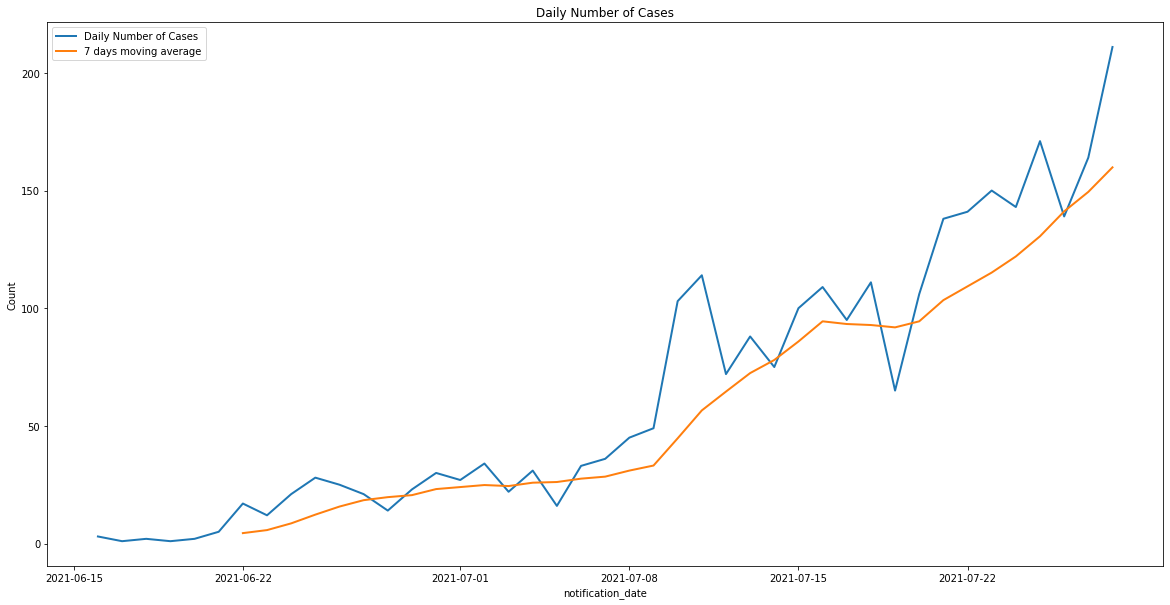

In [517]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x="notification_date", y="Count", data=cases_agg, ax=ax, label="Daily Number of Cases", linewidth=2)
ax = sns.lineplot(x="notification_date", y="Weekly Rolling Average", data=cases_agg, ax=ax, label="7 days moving average", linewidth=2)
ax.set_title("Daily Number of Cases")

[None,
 None,
 Text(0.5, 0, 'Cumulative Number of Cases'),
 Text(0, 0.5, 'Daily New Cases')]

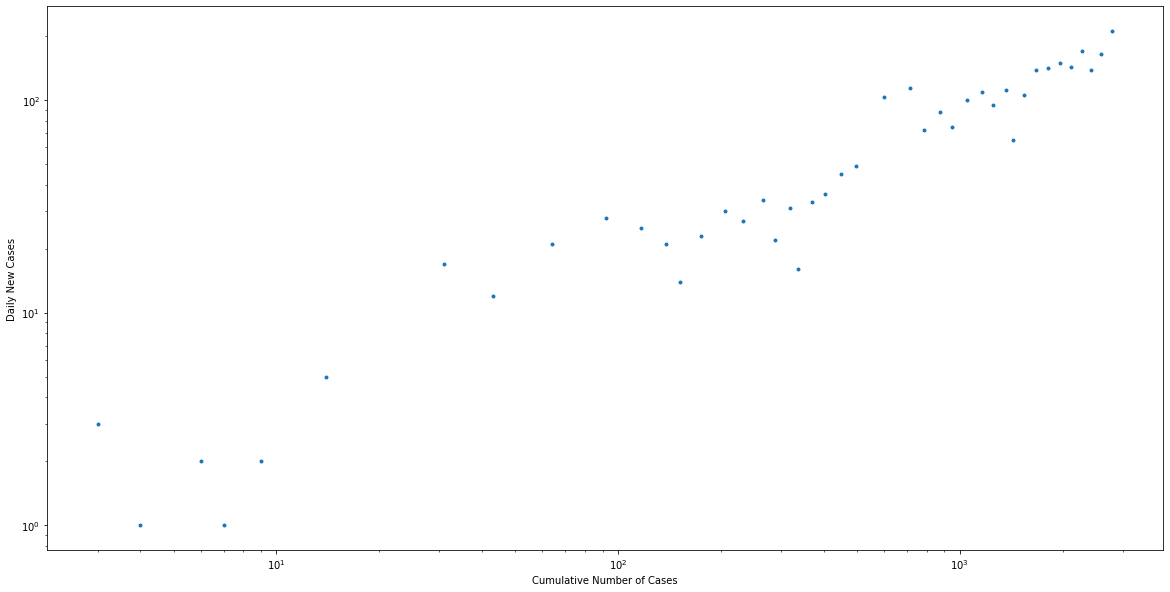

In [518]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="Cumsum", y="Count", data=cases_agg, ax=ax, linewidth=2)
ax.set(yscale="log", xscale="log", xlabel="Cumulative Number of Cases", ylabel="Daily New Cases")

# Models

In [519]:
mask = cases_agg["Epidemiological Days"] >= 0
X = cases_agg.loc[mask, "Epidemiological Days"].values
y = cases_agg.loc[mask, "Weekly Rolling Average"].values

# Bayesian Model 

In [520]:
import pymc3 as pm

In [568]:
# Create PyMC3 context manager
with pm.Model() as model:
    t = pm.Data("x_data", X)
    cases = pm.Data("y_data", y)

    # Intercept - We fixed this at 100.
    a = pm.Normal("a", mu=100, sigma=10)

    # Slope - Growth rate: 0.2 is approx value reported by others
    b = pm.Normal("b", mu=cases_agg["Pct Change"].mean(), sigma=0.5)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)

    trace = pm.sample()
    post_Pred = pm.sample_posterior_predictive(trace)

/tmp/ipykernel_779/259562090.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8880931988620729, but should be close to 0.8. Try to increase the number of tuning steps.


/tmp/ipykernel_779/851248946.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


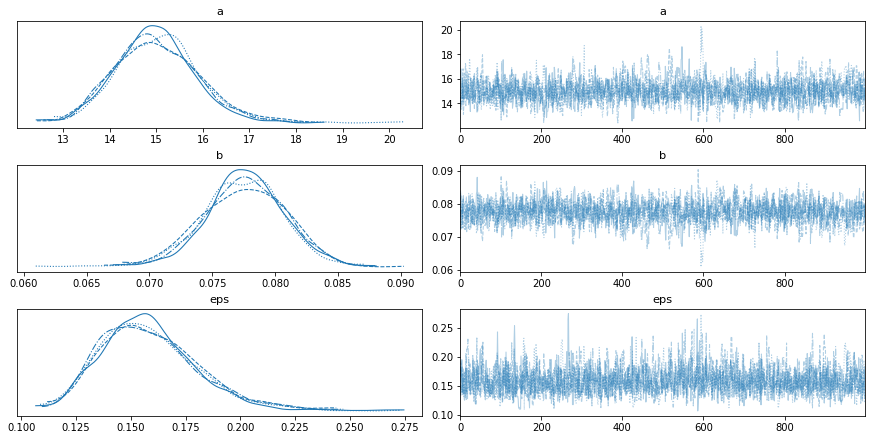

In [569]:
pm.traceplot(trace)
plt.show()

In [570]:
pm.summary(trace).round(2)

/home/vscode/.local/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,15.01,0.89,13.30,16.59,0.02,0.02,1558.0,1352.0,1.0
b,0.08,0.00,0.07,0.08,0.00,0.00,1419.0,1229.0,1.0
eps,0.16,0.02,0.12,0.20,0.00,0.00,1831.0,1907.0,1.0


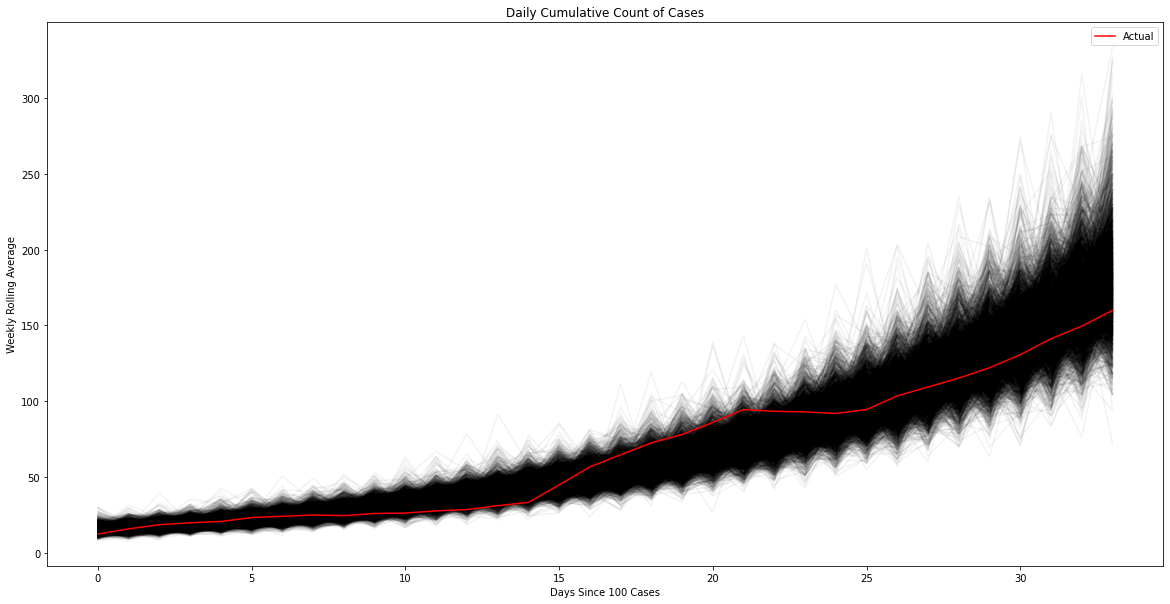

In [581]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(cases_agg.loc[mask, "Epidemiological Days"], post_Pred["cases"].T, color="k", alpha=0.05)
ax.plot(cases_agg.loc[mask, "Epidemiological Days"], cases_agg.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Weekly Rolling Average", title="Daily Cumulative Count of Cases")
ax.legend()
# plt.show()

## Predict on new data

In [579]:
# Update data reference.
pm.set_data({"x_data": X_forecast}, model=model)
# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


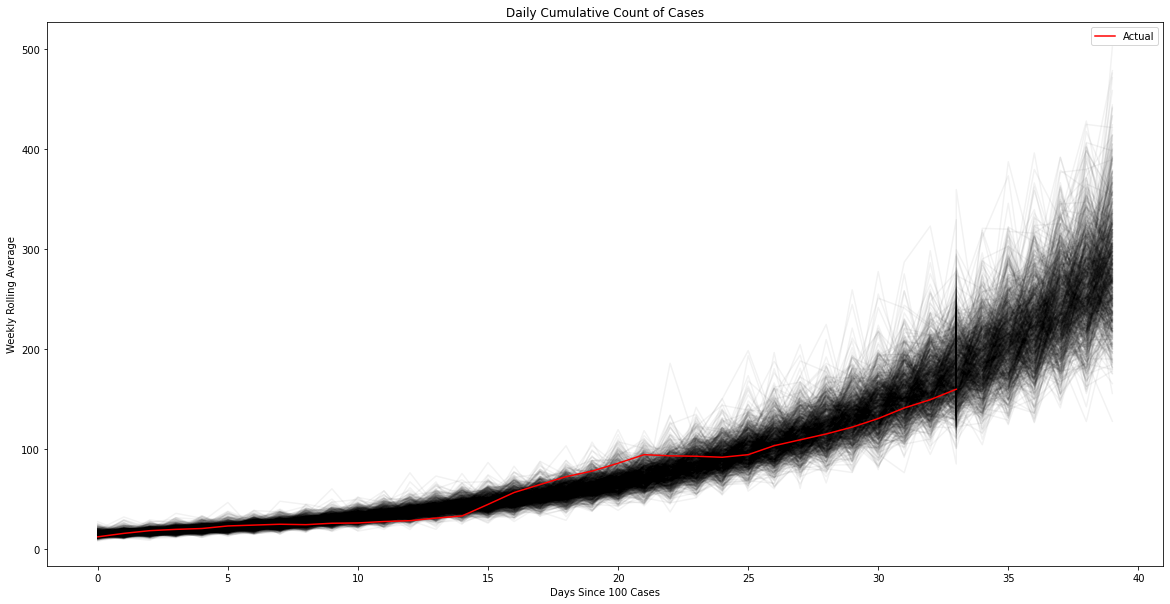

In [580]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X_forecast, ppc_test["cases"].T, color="k", alpha=0.05)
ax.plot(cases_agg.loc[mask, "Epidemiological Days"], cases_agg.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Weekly Rolling Average", title="Daily Cumulative Count of Cases")
ax.legend()
# plt.show()

# Linear Model

In [525]:
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [526]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [583]:
poisson_estimator = PoissonRegressor()
poisson_estimator.fit(X_train.reshape(-1, 1), np.log(y_train))

X_forecast = np.append(X, list(np.arange(X.max(), X.max() + 7)))
y_forecast = poisson_estimator.predict(X_forecast.reshape(-1, 1))
y_pred = poisson_estimator.predict(X.reshape(-1, 1))
y_pred_test = poisson_estimator.predict(X_test.reshape(-1, 1))

R2: 0.9598681843294804
MSE: 0.03295271717931317


/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


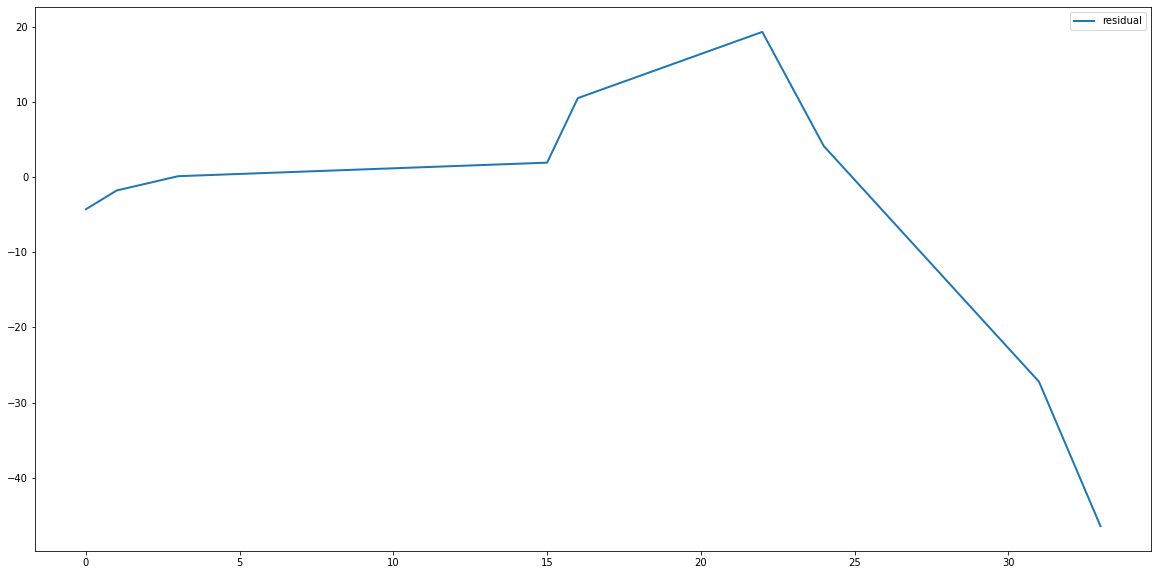

In [584]:
r2 = r2_score(np.log(y_test), y_pred_test)
print("R2:", r2)

mse = mean_squared_error(np.log(y_test), y_pred_test)
print("MSE:", mse)

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(X_test, y_test - np.exp(y_pred_test), ax=ax, label='residual', linewidth=2)

In [585]:
from scipy import stats

def get_prediction_interval(y_true, y_pred, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction

    References:
        [1] https://towardsdatascience.com/prediction-intervals-in-linear-regression-2ea14d419981
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_true - y_pred)**2)
    stdev = np.sqrt(1 / (len(y_true) - 2) * sum_errs)
    
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    #generate prediction interval lower and upper bound
    lower, upper = y_pred - interval, y_pred + interval    
    
    return lower, upper

lower, upper = get_prediction_interval(np.log(y), y_pred)

/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/v

[Text(0, 0.5, 'Seven Days Rolling Averaged Number of Cases'),
 Text(0.5, 0, 'Days Since 100 Cases'),
 Text(0.5, 1.0, 'Seven Days Rolling Averaged Number of Cases per Days Since 100 Cases')]

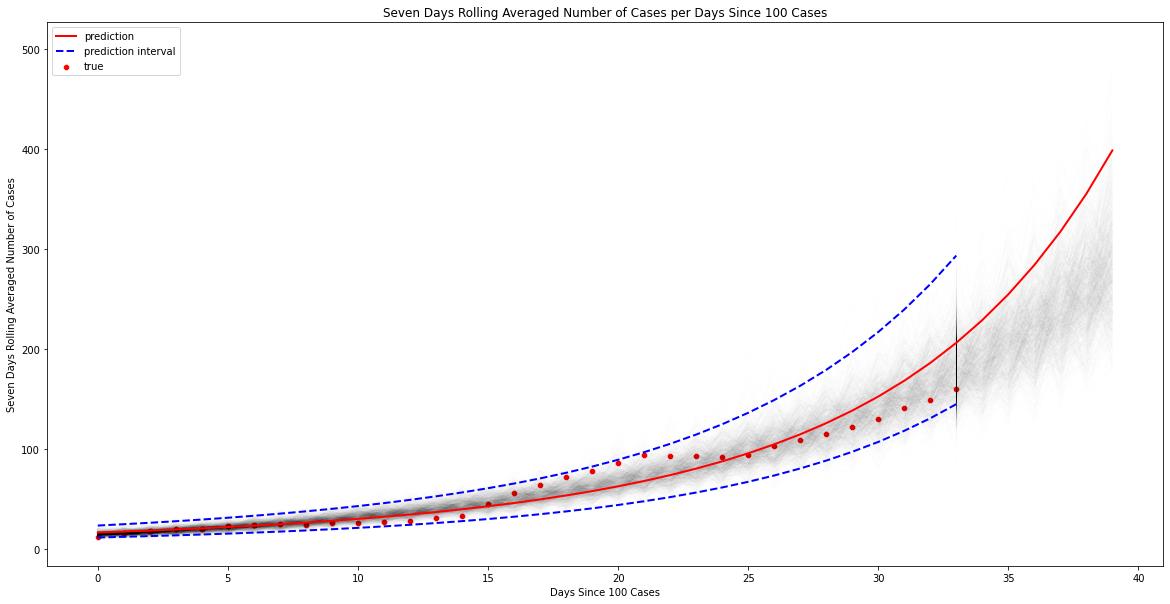

In [594]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(X_forecast, ppc_test["cases"].T, color="k", alpha=0.005)
ax = sns.scatterplot(X, y, ax=ax, label='true', color="red")
ax = sns.lineplot(X_forecast, np.exp(y_forecast), ax=ax, label='prediction', linewidth=2, color="red")
ax = sns.lineplot(X, np.exp(upper), ax=ax, linewidth=2, linestyle="--", color="b", label="prediction interval")
ax = sns.lineplot(X, np.exp(lower), ax=ax, linewidth=2, linestyle="--", color="b")
ax.set(ylabel="Seven Days Rolling Averaged Number of Cases", xlabel="Days Since 100 Cases", title="Seven Days Rolling Averaged Number of Cases per Days Since 100 Cases")

## Stats Models

In [531]:
import statsmodels.api as sm
model = sm.GLM(np.log(y_train), X_train, family=sm.families.Poisson())
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:                            GLM   Df Residuals:                       24
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49.024
Date:                Thu, 29 Jul 2021   Deviance:                       17.159
Time:                        17:42:11   Pearson chi2:                     21.3
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0630      0.005     13.254      0.000       0.054       0.072
==============================================================================
"""

In [532]:
y_pred = model_results.predict(X)

/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/vscode/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

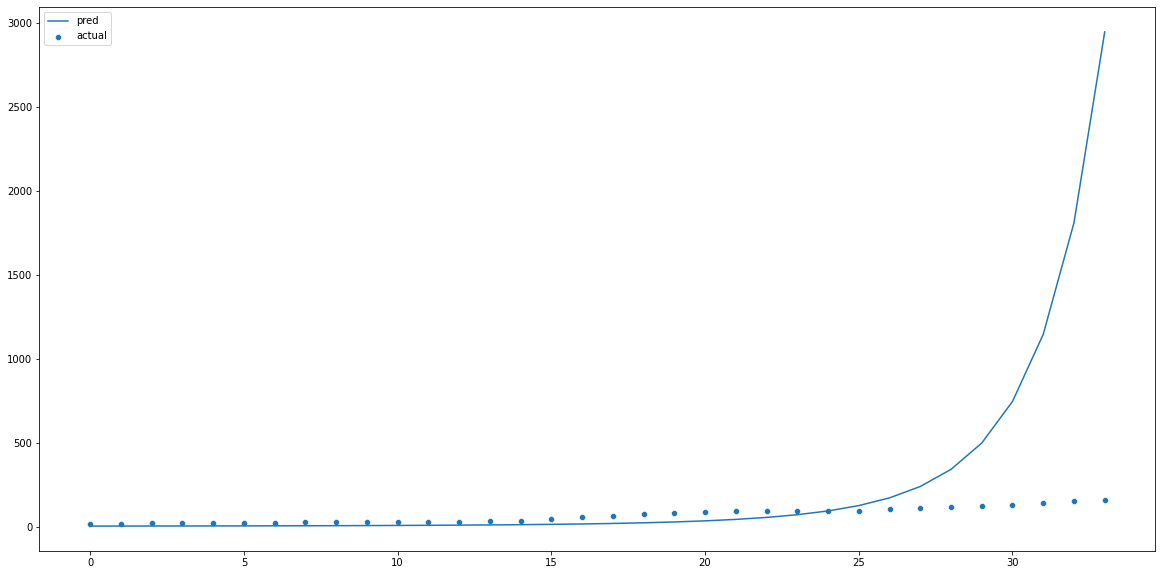

In [533]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(X, y, ax=ax, label='actual')
sns.lineplot(X, np.exp(y_pred), ax=ax, label='pred')

## Fit Logistic Curve

In [478]:
from scipy.optimize import curve_fit

def sigmoid(x, k, x0):

    return 1.0 / (1 + np.exp(-k * (x - x0)))

In [481]:
# Fit the curve
popt, pcov = curve_fit(sigmoid, X_train, y_train)
estimated_k, estimated_x0 = popt
print(estimated_k)
print(estimated_x0)
print(pcov)

66.4875620311215
-85.80013745724203
[[inf inf]
 [inf inf]]


/home/vscode/.local/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


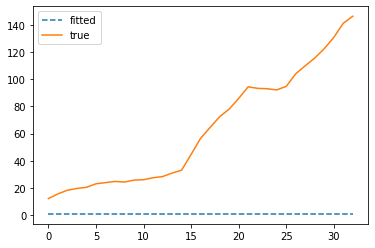

In [482]:
# Plot the fitted curve
y_pred = sigmoid(X, k=estimated_k, x0=estimated_x0)

# Plot everything for illustration
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X, y_pred, '--', label='fitted')
ax.plot(X, y, '-', label='true')


ax.legend()

# References

[1] https://www.architecture-performance.fr/ap_blog/fitting-a-logistic-curve-to-time-series-in-python/

[2] https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python